In [1]:
#Run this cell and then restart the session if operating in kaggle
!pip install -q "numpy>=2.0" "ultralytics>=8.0" "matplotlib>=3.8"

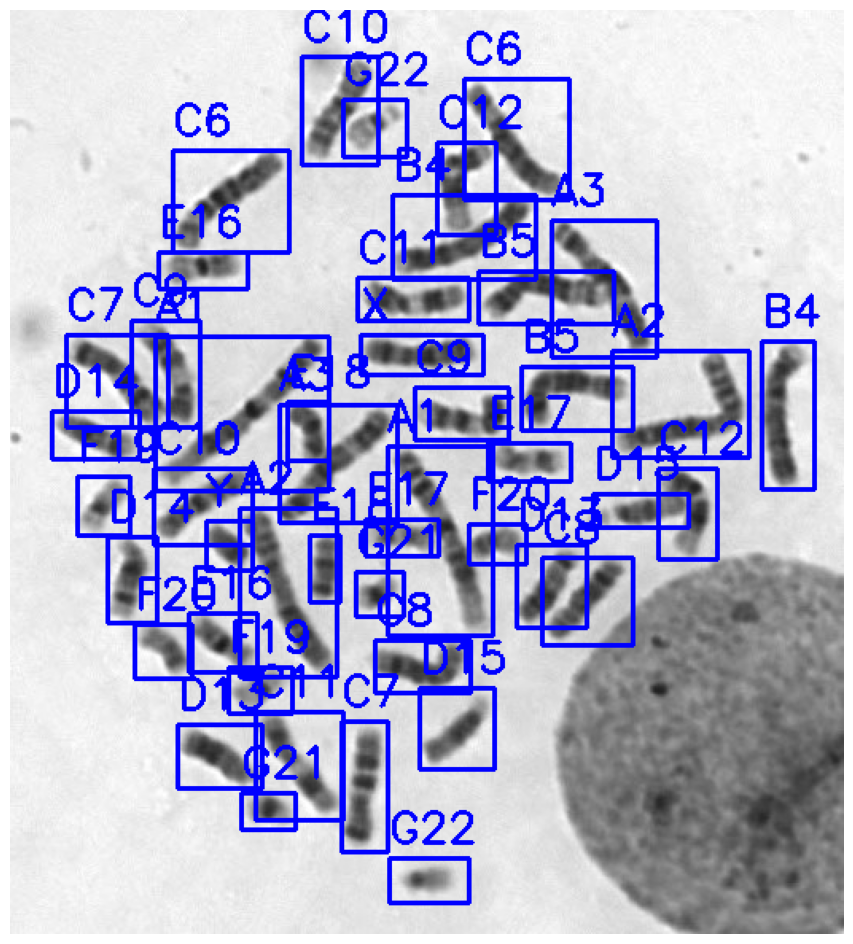

Image saved to /kaggle/working/output_image_with_boxes_24_chromosomes.jpg


In [2]:
#Visualizing the bounding box using one image and it's respective annotation of 24_chromosomes_object

import cv2
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt

def draw_boxes_from_xml_kaggle(image_path, xml_path):
    
    # Check if the image and annotation files exist
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None
    if not os.path.exists(xml_path):
        print(f"Error: Annotation file not found at {xml_path}")
        return None

    # Read the image
    image = cv2.imread(image_path)

    # Parse the XML annotation file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Find and loop through all 'object' tags
    for member in root.findall('object'):
        class_name = member.find('name').text
        bndbox = member.find('bndbox')
        
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Draw the bounding box (blue color, 2 pixel thickness)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return image



my_image_path = '/kaggle/input/chromosomes/24_chromosomes_object/24_chromosomes_object/images/103064.jpg'
my_xml_path = '/kaggle/input/chromosomes/24_chromosomes_object/24_chromosomes_object/annotations/103064.xml'

# 2. Call the function to get the image with boxes
image_with_boxes = draw_boxes_from_xml_kaggle(my_image_path, my_xml_path)

# 3. Display the image inline using Matplotlib
if image_with_boxes is not None:
    # --- IMPORTANT ---
    # OpenCV loads images in BGR format, but Matplotlib displays in RGB.
    # We need to convert the color channels for correct display.
    image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 12)) # Set the figure size
    plt.imshow(image_rgb)
    plt.axis('off') # Hide the axes
    plt.show()

    # Optional: Save the image to the output directory
    output_path = '/kaggle/working/output_image_with_boxes_24_chromosomes.jpg'
    cv2.imwrite(output_path, image_with_boxes)
    print(f"Image saved to {output_path}")



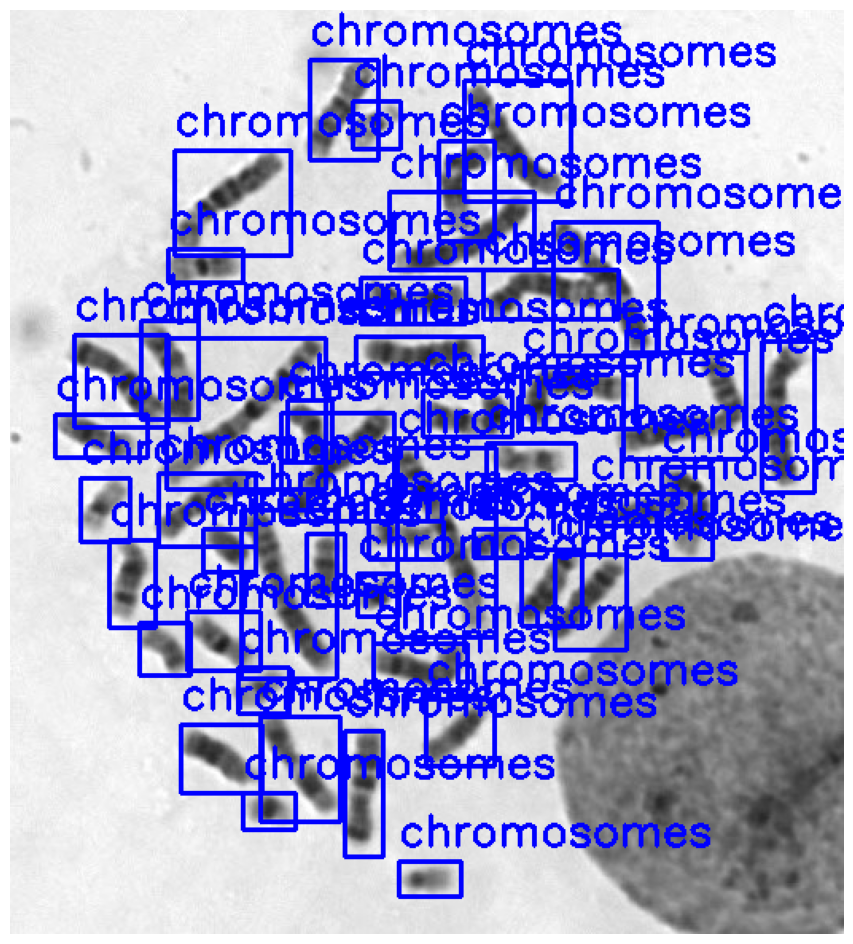

Image saved to /kaggle/working/output_image_with_boxes_single_chromosomes.jpg


In [3]:
#Visualizing the bounding box using one image and it's respective annotation of single_chromosomes_object
import cv2
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt

def draw_boxes_from_xml_kaggle(image_path, xml_path):
    
    # Check if the image and annotation files exist
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None
    if not os.path.exists(xml_path):
        print(f"Error: Annotation file not found at {xml_path}")
        return None

    # Read the image
    image = cv2.imread(image_path)

    # Parse the XML annotation file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Find and loop through all 'object' tags
    for member in root.findall('object'):
        class_name = member.find('name').text
        bndbox = member.find('bndbox')
        
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Draw the bounding box (blue color, 2 pixel thickness)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return image


# --- Example Usage in a Kaggle Notebook ---

# 1. Define the paths to your files in Kaggle
#    (e.g., '/kaggle/input/your-dataset/images/image1.jpg')
my_image_path = '/kaggle/input/chromosomes/single_chromosomes_object/single_chromosomes_object/images/103064.jpg'
my_xml_path = '/kaggle/input/chromosomes/single_chromosomes_object/single_chromosomes_object/annotations/103064.xml'

# 2. Call the function to get the image with boxes
image_with_boxes = draw_boxes_from_xml_kaggle(my_image_path, my_xml_path)

# 3. Display the image inline using Matplotlib
if image_with_boxes is not None:
    # --- IMPORTANT ---
    # OpenCV loads images in BGR format, but Matplotlib displays in RGB.
    # We need to convert the color channels for correct display.
    image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 12)) # Set the figure size
    plt.imshow(image_rgb)
    plt.axis('off') # Hide the axes
    plt.show()

    # Optional: Save the image to the output directory
    output_path = '/kaggle/working/output_image_with_boxes_single_chromosomes.jpg'
    cv2.imwrite(output_path, image_with_boxes)
    print(f"Image saved to {output_path}")


In [4]:
#Main code starts from here, We are starting with the model which will just detect the chromosome  
import os
import shutil
import xml.etree.ElementTree as ET
from PIL import Image 

#Function to convert the XML file to a list of YOLO formatted strings.
def convert_xml_to_yolo(xml_path, class_map, img_width, img_height):
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_lines = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_map:
            continue
        class_id = class_map[class_name]

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        x_center = (xmin + xmax) / 2.0 / img_width
        y_center = (ymin + ymax) / 2.0 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
    return yolo_lines

#Main Data Preparation Script 




# Source paths where your original data is stored
IMAGES_SOURCE_DIR = "/kaggle/input/chromosomes/single_chromosomes_object/single_chromosomes_object/images"
ANNOTATIONS_SOURCE_DIR = "/kaggle/input/chromosomes/single_chromosomes_object/single_chromosomes_object/annotations"
TRAIN_LIST_FILE = "/kaggle/input/chromosomes/single_chromosomes_object/single_chromosomes_object/train.txt"
VAL_LIST_FILE="/kaggle/input/chromosomes/single_chromosomes_object/single_chromosomes_object/train.txt"

# Output paths in the writable Kaggle directory
DATASET_DIR = "/kaggle/working/chromosome_dataset_detection"
TRAIN_IMG_DIR = os.path.join(DATASET_DIR, "images/train")
VAL_IMG_DIR = os.path.join(DATASET_DIR, "images/val")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "labels/train")
VAL_LABEL_DIR = os.path.join(DATASET_DIR, "labels/val")
os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(VAL_IMG_DIR, exist_ok=True)
os.makedirs(TRAIN_LABEL_DIR, exist_ok=True)
os.makedirs(VAL_LABEL_DIR, exist_ok=True)

# Function to copy files based on a list
CLASS_MAP = {'chromosomes': 0}

# --- Function to process files ---
def process_and_copy_files(list_file, dest_img_dir, dest_label_dir):
    with open(list_file, 'r') as f:
        file_list = [line.strip() for line in f.readlines()]
    
    print(f"Processing {len(file_list)} files from {os.path.basename(list_file)}...")
    for filename in file_list:
        clean_basename = os.path.splitext(filename)[0]
        
        img_src_path = os.path.join(IMAGES_SOURCE_DIR, f"{clean_basename}.jpg")
        xml_src_path = os.path.join(ANNOTATIONS_SOURCE_DIR, f"{clean_basename}.xml")

        if os.path.exists(img_src_path) and os.path.exists(xml_src_path):
            # 1. Copy the image file
            shutil.copy(img_src_path, dest_img_dir)
            
            # 2. Get image dimensions for conversion
            with Image.open(img_src_path) as img:
                img_width, img_height = img.size
            
            # 3. Convert the XML annotation to YOLO format
            yolo_data = convert_xml_to_yolo(xml_src_path, CLASS_MAP, img_width, img_height)
            
            # 4. Write the new .txt label file
            label_dest_path = os.path.join(dest_label_dir, f"{clean_basename}.txt")
            with open(label_dest_path, 'w') as f:
                f.write("\n".join(yolo_data))
        

# --- Run the processing ---
print("Copying training files and converting labels...")
process_and_copy_files(TRAIN_LIST_FILE, TRAIN_IMG_DIR, TRAIN_LABEL_DIR)

print("\nCopying validation files and converting labels...")
process_and_copy_files(VAL_LIST_FILE, VAL_IMG_DIR, VAL_LABEL_DIR)

print("\nData preparation and conversion complete! ✅")

Copying training files and converting labels...
Processing 3750 files from train.txt...

Copying validation files and converting labels...
Processing 3750 files from train.txt...

Data preparation and conversion complete! ✅


In [5]:
#Creating a .yaml file 
import yaml

yaml_config = {
    'train': '/kaggle/working/chromosome_dataset_detection/images/train',
    'val': '/kaggle/working/chromosome_dataset_detection/images/val',
    'nc': 1,
    'names': ['chromosomes']
}

with open('/kaggle/working/chromosome_detection.yaml', 'w') as file:
    yaml.dump(yaml_config, file, default_flow_style=False)

print("chromosome_detection.yaml created successfully!")

chromosome_detection.yaml created successfully!


In [7]:
#training the model
from ultralytics import YOLO


model = YOLO('yolov8n.pt')

# Train the model
results = model.train(
    data='/kaggle/working/chromosome_detection.yaml',
    epochs=40,
    imgsz=640,
    batch=16,
    degrees=90,  
    flipud=0.5,
    project='/kaggle/working/runs_detection' # Save results to the working directory
)

Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/chromosome_detection.yaml, degrees=90, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

Visualizing for image: 1055271.jpg

image 1/1 /kaggle/working/chromosome_dataset_detection/images/val/1055271.jpg: 608x640 51 chromosomess, 33.2ms
Speed: 2.7ms preprocess, 33.2ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


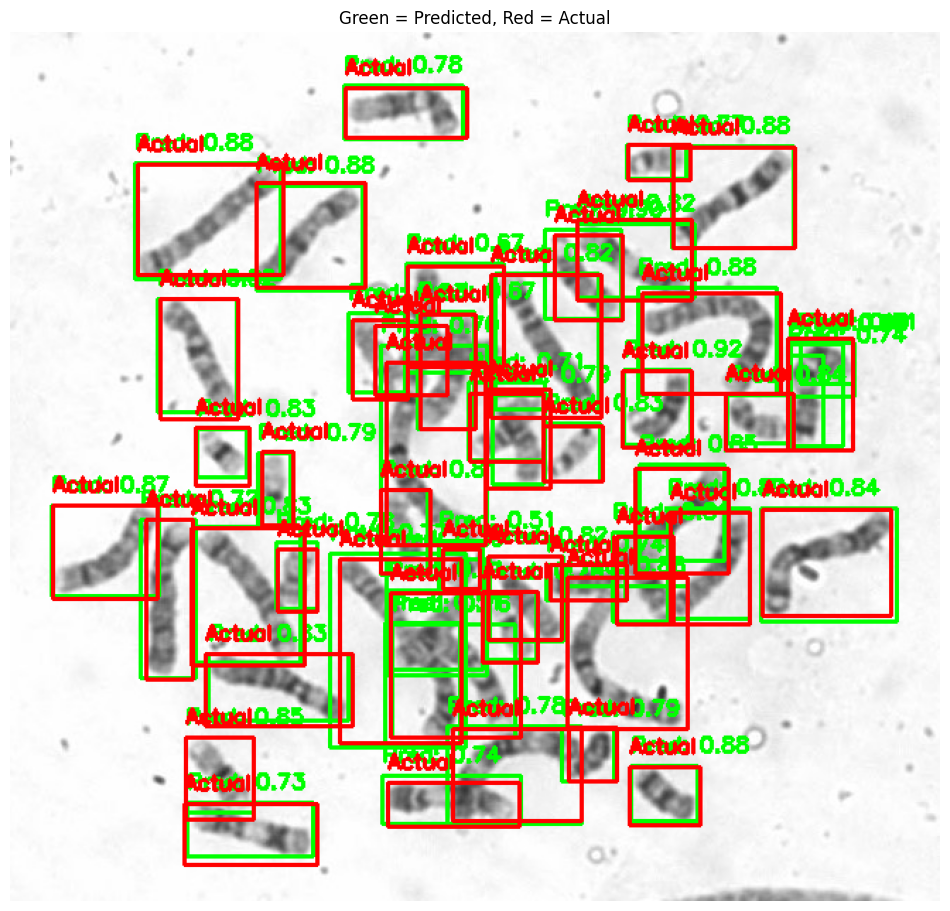

In [8]:
#Visualizing the actual and predicted bounding boxes made by our model on any of the test set images 
import os
import random
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- Configuration ---

# 1. Path to your trained model weights
MODEL_PATH = '/kaggle/working/runs_detection/train2/weights/best.pt'

# 2. Path to the folder with your validation images
VAL_IMAGES_DIR = '/kaggle/working/chromosome_dataset_detection/images/val/'

# 3. Path to the folder with your ORIGINAL XML annotations
# This is needed to get the ground truth boxes
ORIGINAL_ANNOTATIONS_DIR = '/kaggle/input/chromosomes/single_chromosomes_object/single_chromosomes_object/annotations'

# --- Load Model ---
model = YOLO(MODEL_PATH)

# --- Select a Random Image ---
# Get a list of all image files in the validation directory
image_files = [f for f in os.listdir(VAL_IMAGES_DIR) if f.endswith('.jpg')]

if not image_files:
    print("Error: No validation images found. Please check the VAL_IMAGES_DIR path.")
else:
    # Pick one random image
    random_image_name = random.choice(image_files)
    image_path = os.path.join(VAL_IMAGES_DIR, random_image_name)
    print(f"Visualizing for image: {random_image_name}")

    # --- Read the Image ---
    # We use cv2 to read the image for drawing boxes on it
    image = cv2.imread(image_path)
    # Convert from BGR (cv2 default) to RGB for correct color display with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # --- Get Model Predictions ---
    results = model(image_path)
    
    # --- Draw PREDICTED Bounding Boxes (Green) ---
    for result in results:
        for box in result.boxes:
            # Get coordinates in (top, left, bottom, right) format
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]
            
            # Draw the rectangle
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green color, thickness 2
            
            # Put label and confidence score
            label = f"Pred: {confidence:.2f}"
            cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # --- Get and Draw ACTUAL Bounding Boxes (Red) ---
    clean_basename = os.path.splitext(random_image_name)[0]
    xml_path = os.path.join(ORIGINAL_ANNOTATIONS_DIR, f"{clean_basename}.xml")
    
    if os.path.exists(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Draw the ground truth rectangle
            cv2.rectangle(image_rgb, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2) # Red color, thickness 2
            cv2.putText(image_rgb, "Actual", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    else:
        print(f"Warning: Could not find ground truth XML file at {xml_path}")

    # --- Display the Final Image ---
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title("Green = Predicted, Red = Actual")
    plt.axis('off') # Hide axes
    plt.show()

In [9]:
#testing the model on the entire dataset and then evaluating the metrics 
from ultralytics import YOLO

model_path = '/kaggle/working/runs_detection/train2/weights/best.pt'
model = YOLO(model_path)


metrics = model.val(data='/kaggle/working/chromosome_detection.yaml')

print("\n--- Detailed Metrics ---")
print(f"mAP50-95 (Box): {metrics.box.map:.4f}")
print(f"mAP50 (Box): {metrics.box.map50:.4f}")
print(f"mAP75 (Box): {metrics.box.map75:.4f}")

Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1959.6±441.0 MB/s, size: 104.7 KB)
val: Scanning /kaggle/working/chromosome_dataset_detection/labels/val.cache... 719 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 719/719 1.1Mit/s 0.0s0s
val: /kaggle/working/chromosome_dataset_detection/images/val/104241.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_detection/images/val/1051004.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_detection/images/val/1052224.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_detection/images/val/1052481.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_detection/images/val/1054563.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_detection/im

In [10]:
#Now we will implement the model of clasification of chromosomes using the dataset 24_chromosomes_object
import os
import shutil
import xml.etree.ElementTree as ET
from PIL import Image 

#Function to convert the XML file to a list of YOLO formatted strings.
def convert_xml_to_yolo(xml_path, class_map, img_width, img_height):
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_lines = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_map:
            continue
        class_id = class_map[class_name]

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        x_center = (xmin + xmax) / 2.0 / img_width
        y_center = (ymin + ymax) / 2.0 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
    return yolo_lines

#Main Data Preparation Script 




# Source paths where your original data is stored
IMAGES_SOURCE_DIR = "/kaggle/input/chromosomes/24_chromosomes_object/24_chromosomes_object/images"
ANNOTATIONS_SOURCE_DIR = "/kaggle/input/chromosomes/24_chromosomes_object/24_chromosomes_object/annotations"
TRAIN_LIST_FILE = "/kaggle/input/chromosomes/24_chromosomes_object/24_chromosomes_object/train.txt"
VAL_LIST_FILE="/kaggle/input/chromosomes/24_chromosomes_object/24_chromosomes_object/train.txt"

# Output paths in the writable Kaggle directory
DATASET_DIR = "/kaggle/working/chromosome_dataset_classification"
TRAIN_IMG_DIR = os.path.join(DATASET_DIR, "images/train")
VAL_IMG_DIR = os.path.join(DATASET_DIR, "images/val")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "labels/train")
VAL_LABEL_DIR = os.path.join(DATASET_DIR, "labels/val")
os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(VAL_IMG_DIR, exist_ok=True)
os.makedirs(TRAIN_LABEL_DIR, exist_ok=True)
os.makedirs(VAL_LABEL_DIR, exist_ok=True)

# Function to copy files based on a list
CLASS_MAP = {
    'A1': 0, 'A2': 1, 'A3': 2, 'B4': 3, 'B5': 4, 'C6': 5, 'C7': 6,
    'C8': 7, 'C9': 8, 'C10': 9, 'C11': 10, 'C12': 11, 'D13': 12,
    'D14': 13, 'D15': 14, 'E16': 15, 'E17': 16, 'E18': 17, 'F19': 18,
    'F20': 19, 'G21': 20, 'G22': 21, 'X': 22, 'Y': 23
}

# --- Function to process files ---
def process_and_copy_files(list_file, dest_img_dir, dest_label_dir):
    with open(list_file, 'r') as f:
        file_list = [line.strip() for line in f.readlines()]
    
    print(f"Processing {len(file_list)} files from {os.path.basename(list_file)}...")
    for filename in file_list:
        clean_basename = os.path.splitext(filename)[0]
        
        img_src_path = os.path.join(IMAGES_SOURCE_DIR, f"{clean_basename}.jpg")
        xml_src_path = os.path.join(ANNOTATIONS_SOURCE_DIR, f"{clean_basename}.xml")

        if os.path.exists(img_src_path) and os.path.exists(xml_src_path):
            # 1. Copy the image file
            shutil.copy(img_src_path, dest_img_dir)
            
            # 2. Get image dimensions for conversion
            with Image.open(img_src_path) as img:
                img_width, img_height = img.size
            
            # 3. Convert the XML annotation to YOLO format
            yolo_data = convert_xml_to_yolo(xml_src_path, CLASS_MAP, img_width, img_height)
            
            # 4. Write the new .txt label file
            label_dest_path = os.path.join(dest_label_dir, f"{clean_basename}.txt")
            with open(label_dest_path, 'w') as f:
                f.write("\n".join(yolo_data))
        

# --- Run the processing ---
print("Copying training files and converting labels...")
process_and_copy_files(TRAIN_LIST_FILE, TRAIN_IMG_DIR, TRAIN_LABEL_DIR)

print("\nCopying validation files and converting labels...")
process_and_copy_files(VAL_LIST_FILE, VAL_IMG_DIR, VAL_LABEL_DIR)

print("\nData preparation and conversion complete! ✅")

Copying training files and converting labels...
Processing 3750 files from train.txt...

Copying validation files and converting labels...
Processing 3750 files from train.txt...

Data preparation and conversion complete! ✅


In [11]:
#Creating a .yaml file 
import yaml
class_names = [
    'A1', 'A2', 'A3', 'B4', 'B5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 
    'F20', 'G21', 'G22', 'X', 'Y'
]

yaml_config = {
    'train': '/kaggle/working/chromosome_dataset_classification/images/train',
    'val': '/kaggle/working/chromosome_dataset_classification/images/val',
    'nc': 24,
    'names': class_names
}

with open('/kaggle/working/chromosome_classification.yaml', 'w') as file:
    yaml.dump(yaml_config, file, default_flow_style=False)

print("chromosome_classification.yaml created successfully!")

chromosome_classification.yaml created successfully!


In [12]:
#training the model
from ultralytics import YOLO

# Load a pretrained model
model = YOLO('yolov8n.pt')

# Train the model
results = model.train(
    data='/kaggle/working/chromosome_classification.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    degrees=90,  
    flipud=0.5,
    project='/kaggle/working/runs_classification' # Save results to the working directory
)

Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/chromosome_classification.yaml, degrees=90, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

Visualizing for image: 1100512.jpg

image 1/1 /kaggle/working/chromosome_dataset_classification/images/val/1100512.jpg: 480x640 2 A1s, 2 A2s, 2 A3s, 2 B4s, 2 B5s, 2 C6s, 2 C7s, 5 C8s, 4 C9s, 2 C10s, 2 C11s, 2 C12s, 2 D13s, 2 D14s, 4 D15s, 2 E16s, 1 E17, 2 E18s, 2 F19s, 2 F20s, 2 G21s, 2 G22s, 4 Xs, 1 Y, 35.2ms
Speed: 4.7ms preprocess, 35.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


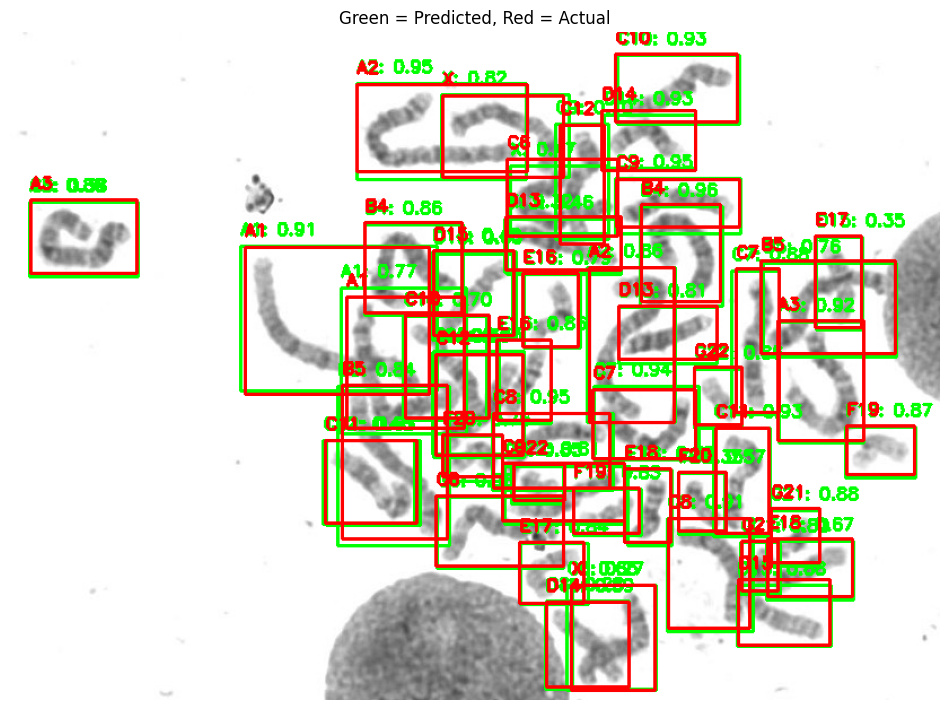

In [13]:
#Visualizing the actual and predicted bounding boxes made by our model on any of the test set images 
 

import os
import random
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- Configuration ---

# 1. Path to your trained model weights
MODEL_PATH = '/kaggle/working/runs_classification/train/weights/best.pt'

# 2. Path to the folder with your validation images
VAL_IMAGES_DIR = '/kaggle/working/chromosome_dataset_classification/images/val/'

# 3. Path to the folder with your ORIGINAL XML annotations
ORIGINAL_ANNOTATIONS_DIR = '/kaggle/input/chromosomes/24_chromosomes_object/24_chromosomes_object/annotations'

# --- Load Model ---
model = YOLO(MODEL_PATH)

# --- Select a Random Image ---
image_files = [f for f in os.listdir(VAL_IMAGES_DIR) if f.endswith('.jpg')]

if not image_files:
    print("Error: No validation images found. Please check the VAL_IMAGES_DIR path.")
else:
    random_image_name = random.choice(image_files)
    image_path = os.path.join(VAL_IMAGES_DIR, random_image_name)
    print(f"Visualizing for image: {random_image_name}")

    # --- Read the Image ---
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # --- Get Model Predictions ---
    results = model(image_path)
    
    # --- Draw PREDICTED Bounding Boxes (Green) ---
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]
            
            # --- CHANGE 1: Get the predicted class name ---
            class_id = int(box.cls[0])
            class_name = model.names[class_id]
            label = f"{class_name}: {confidence:.2f}"
            
            # Draw the rectangle and label
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # --- Get and Draw ACTUAL Bounding Boxes (Red) ---
    clean_basename = os.path.splitext(random_image_name)[0]
    xml_path = os.path.join(ORIGINAL_ANNOTATIONS_DIR, f"{clean_basename}.xml")
    
    if os.path.exists(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            # --- CHANGE 2: Get the actual class name ---
            actual_class_name = obj.find('name').text
            
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Draw the ground truth rectangle and label
            cv2.rectangle(image_rgb, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image_rgb, actual_class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    else:
        print(f"Warning: Could not find ground truth XML file at {xml_path}")

    # --- Display the Final Image ---
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title("Green = Predicted, Red = Actual")
    plt.axis('off')
    plt.show()

In [14]:
#testing the model on the entire dataset and then evaluating the metrics 


model_path = '/kaggle/working/runs_classification/train/weights/best.pt'
model = YOLO(model_path)


metrics = model.val(data='/kaggle/working/chromosome_classification.yaml')

print("\n--- Detailed Metrics ---")
print(f"mAP50-95 (Box): {metrics.box.map:.4f}")
print(f"mAP50 (Box): {metrics.box.map50:.4f}")
print(f"mAP75 (Box): {metrics.box.map75:.4f}")

Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,010,328 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1589.8±705.7 MB/s, size: 81.5 KB)
val: Scanning /kaggle/working/chromosome_dataset_classification/labels/val.cache... 3744 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3744/3744 6.9Mit/s 0.0s
val: /kaggle/working/chromosome_dataset_classification/images/val/104241.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_classification/images/val/1051004.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_classification/images/val/1052224.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_classification/images/val/1052481.jpg: corrupt JPEG restored and saved
val: /kaggle/working/chromosome_dataset_classification/images/val/1054563.jpg: corrupt JPEG restored and saved
val: /kaggle/working/c